# Lane Lines Detection

## I. Lane Lines Detection on Image 

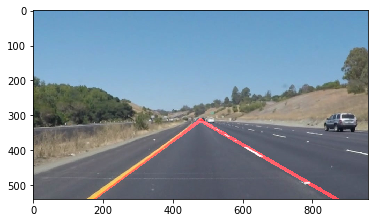

In [56]:
# Setup import the required library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.interpolate as interpolate
import cv2
from PIL import Image

# Pipeline function to process image
def pipeline(image, output_file=False, show_image=False, ):
    # Copies of the image
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    copy_image = np.copy(image) # create another copy for the line drawing at the end
    
    # Grayscale image
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian smoothing to reduce noise
    blur_gray = cv2.GaussianBlur(gray,(5, 5),0)
    if show_image:
        plt.imshow(blur_gray, cmap='gray')
        plt.show()
    
    # Cannyfy to extract edges
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    if show_image:
        plt.imshow(edges)
        plt.show()

    # Create a polygon mask to select region of interest
    # Here I divided them into two sections for easier averaging post-Hough
    ignore_mask_color = 255   
    imshape = image.shape
    
    mask_left = np.zeros_like(edges)   
    vertices_left = np.array([[(0,imshape[0]),(450, imshape[0]*0.6), (475, imshape[0]*0.6), (475,imshape[0])]], dtype=np.int32)
    mask_right = np.zeros_like(edges)   
    vertices_right = np.array([[(475,imshape[0]),(475, imshape[0]*0.6), (500, imshape[0]*0.6), (imshape[1],imshape[0])]], dtype=np.int32)
    
    cv2.fillPoly(mask_left, vertices_left, ignore_mask_color)
    masked_edges_left = cv2.bitwise_and(edges, mask_left)
    
    cv2.fillPoly(mask_right, vertices_right, ignore_mask_color)
    masked_edges_right = cv2.bitwise_and(edges, mask_right)
    
    lines_left, lines_right = Hough_transform(masked_edges_left, masked_edges_right)
    
    lines_left_extended, lines_right_extended = extrapolate(imshape, lines_left, lines_right)
    lines = np.append([lines_left_extended], [lines_right_extended], axis=0)

#     line_fitting(imshape, lines_left, lines_right)

    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
            
     # Apply lines as overlay on the image
    copy_edges = cv2.addWeighted(line_image, 0.8, copy_image, 1, 0) 
    
    if show_image:
        plt.imshow(copy_edges)
        plt.show()

    # To save the images(s)
    if output_file:
        im = Image.fromarray(copy_image)
        im.save(output_file)
    
    return copy_edges

# No good as a function, but as a section of a whole is convenient. Change params here to experiment.
def Hough_transform(masked_edges_left, masked_edges_right):
    # Define the Hough transform parameters
    # Hough parameters setup
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = 2*np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 300    # maximum gap in pixels between connectable line segments
    
    # Run Hough on edge detected
    # Output "lines" is an array containing endpoints of detected line segments
    lines_left = cv2.HoughLinesP(masked_edges_left, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    lines_right = cv2.HoughLinesP(masked_edges_right, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    
    return [lines_left, lines_right]

def predict_y(coord_x, lines):
    x, y = [], []
    for line in lines:
        for x1, y1, x2, y2 in line:
            x.append(x1)
            y.append(y1)
            x.append(x2)
            y.append(y2)
            
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        return p(coord_x)
        
def extrapolate(imshape, lines_left, lines_right):
    lines_left_extended = [np.array([0, int(predict_y(0, lines_left)), int(imshape[1]/2), int(predict_y(imshape[1]/2, lines_left))])]
    lines_right_extended = [np.array([int(imshape[1]/2), int(predict_y(imshape[1]/2, lines_right)), imshape[1], int(predict_y(imshape[1], lines_right))])]
    
    return lines_left_extended, lines_right_extended

# First image test
plt.imshow(pipeline(mpimg.imread('./test_images/solidYellowCurve.jpg'), './result_images/solidYellowCurve.png'))
plt.show()

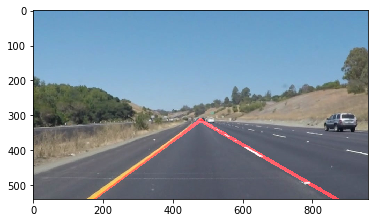

In [59]:
# First image test
plt.imshow(pipeline(mpimg.imread('./test_images/solidYellowCurve.jpg'), './result_images/solidYellowCurve.png'))
plt.show()

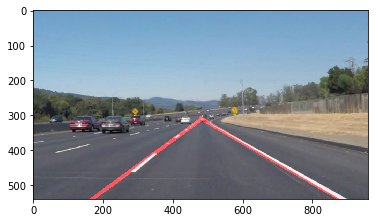

In [60]:
plt.imshow(pipeline(mpimg.imread('./test_images/solidWhiteCurve.jpg'), './result_images/solidWhiteCurve.png'))
plt.show()

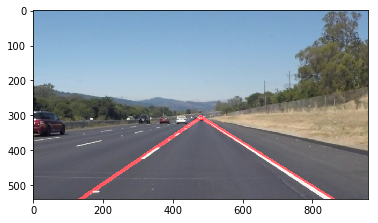

In [61]:
plt.imshow(pipeline(mpimg.imread('./test_images/solidWhiteRight.jpg'), './result_images/solidWhiteRight.png'))
plt.show()

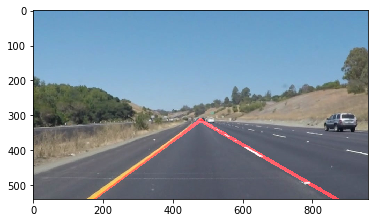

In [62]:
plt.imshow(pipeline(mpimg.imread('./test_images/solidYellowCurve.jpg'), './result_images/solidYellowCurve.png'))
plt.show()

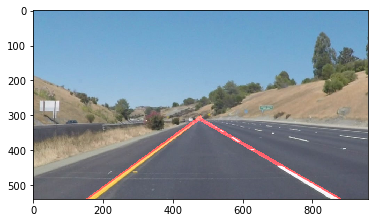

In [63]:
plt.imshow(pipeline(mpimg.imread('./test_images/solidYellowCurve2.jpg'), './result_images/solidYellowCurve2.png'))
plt.show()

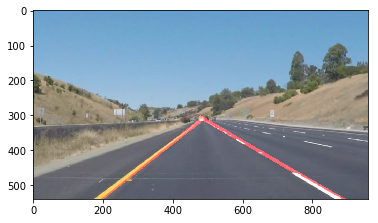

In [64]:
plt.imshow(pipeline(mpimg.imread('./test_images/whiteCarLaneSwitch.jpg'), './result_images/whiteCarLaneSwitch.png'))
plt.show()

## II. Lane Lines Detection in Video

In [65]:
# Time to process the video. 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [58]:
# Create new video files. Can do loop but cannot bother atm.
# new_clip_output = './result_videos/solidWhiteRight.mp4'
# test_clip = VideoFileClip("./test_videos/solidWhiteRight.mp4")
# new_clip = test_clip.fl_image(lambda x: pipeline(x)) #NOTE: this function expects color images!!
# %time new_clip.write_videofile(new_clip_output, audio=False)

# new_clip_output1 = './result_videos/solidYellowLeft.mp4'
# test_clip1 = VideoFileClip("./test_videos/solidYellowLeft.mp4")
# new_clip1 = test_clip1.fl_image(lambda x: pipeline(x)) #NOTE: this function expects color images!!
# %time new_clip1.write_videofile(new_clip_output1, audio=False)

new_clip_output2 = './result_videos/challenge.mp4'
test_clip2 = VideoFileClip("./test_videos/challenge.mp4")
new_clip2 = test_clip2.fl_image(lambda x: pipeline(x)) #NOTE: this function expects color images!!
%time new_clip2.write_videofile(new_clip_output2, audio=False)


#Currently failing challenge.

[MoviePy] >>>> Building video ./result_videos/challenge.mp4
[MoviePy] Writing video ./result_videos/challenge.mp4



100%|██████████| 251/251 [00:13<00:00, 18.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./result_videos/challenge.mp4 

CPU times: user 6.32 s, sys: 944 ms, total: 7.27 s
Wall time: 15.9 s


In [45]:
# # Render
# HTML("""
# <video width="640" height="300" controls>
#   <source src="{0}" type="video/mp4">
# </video>
# """.format(new_clip_output))